In [127]:
import sys
import numpy as np
import argparse
from math import *

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\code\\myPy')  
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\CUDA\\RSgpu\\Release')
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
import ablation_utils
import geom
import sonalleve
import transducers
import PBHE_CUDA

import importlib

import matplotlib.image as image
import matplotlib.pyplot as plt

import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage

def plotTraj(vec,maxR_mm=10,dR_mm=4,z_mm=140):
    points,nt,numSon = ablation_utils.contstruct_circ_sonication_points(maxR_mm,dR_mm,z_mm,vec[0],vec[1],vec[2])
    plt.plot(points[:,0], points[:,1], '*-')
    return points


%matplotlib inline

In [301]:
importlib.reload(ablation_utils)

<module 'ablation_utils' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims\\ablation_utils.py'>

In [2]:
rho=1000
Cp=3700
c0=1540
f0=1.2e6
k0=f0*2*pi/c0
ktdiffusion=0.6

uxyz = sonalleve.get_sonalleve_xdc_vecs()
unvec = sonalleve.get_sonalleve_xdc_normals()

In [3]:
dataType=np.float32

nt=30
nx=62; ny=62; nz=62;
T=np.zeros([nt,nx,ny,nz],dtype=dataType)
Tdot=np.zeros([nx,ny,nz],dtype=dataType)
kdiff=np.zeros([nx,ny,nz],dtype=dataType)
rhoCp=np.zeros([nx,ny,nz],dtype=dataType)

CEM=np.zeros([nx,ny,nz],dtype=dataType)
CEM0=np.zeros_like(CEM)

xrp = 1e-2*np.linspace(-2.0,2.0, nx, dtype=dataType)
yrp = 1e-2*np.linspace(-2.0,2.0, ny, dtype=dataType)
zrp = 1e-2*np.linspace(11.0, 17.0, nz, dtype=dataType)
dx=xrp[1]-xrp[0]
dy=yrp[1]-yrp[0]
dz=zrp[1]-zrp[0]
dt=0.1

zplane=0.14
focplaneZpix=np.where(np.logical_and( (zrp[1:-1]-zplane>=0) , (zrp[0:-2]-zplane<0) ))[0][0]

res = np.array([dt,dx,dy,dz],dtype=dataType)

kdiff[:]=ktdiffusion
rhoCp[:]= rho*Cp

if dataType == np.float32:
    Tmesh = PBHE_CUDA.mesh4d_f()
    Tdotmesh = PBHE_CUDA.mesh34d_f();
    kmesh = PBHE_CUDA.mesh3d_f();
    rhoCpmesh = PBHE_CUDA.mesh3d_f();


    PBHE_CUDA.ShareMemoryMesh4_f(T, res, Tmesh)
    PBHE_CUDA.ShareMemoryMesh34_f(Tdot, res, Tdotmesh)
    PBHE_CUDA.ShareMemoryMesh3_f(kdiff, res[1:4], kmesh)
    PBHE_CUDA.ShareMemoryMesh3_f(rhoCp, res[1:4], rhoCpmesh)
else:
    Tmesh = PBHE_CUDA.mesh4d()
    Tdotmesh = PBHE_CUDA.mesh34d();
    kmesh = PBHE_CUDA.mesh3d();
    rhoCpmesh = PBHE_CUDA.mesh3d();

    PBHE_CUDA.ShareMemoryMesh4(T, res, Tmesh)
    PBHE_CUDA.ShareMemoryMesh34(Tdot, res, Tdotmesh)
    PBHE_CUDA.ShareMemoryMesh3(kdiff, res[1:4], kmesh)
    PBHE_CUDA.ShareMemoryMesh3(rhoCp, res[1:4], rhoCpmesh)
    
gxp,gyp,gzp = np.meshgrid(xrp, yrp, zrp, sparse=False, indexing='ij')
calcGridDist= lambda rr: np.sqrt((gxp-rr[0])**2 + (gyp-rr[1])**2 + (gzp-rr[2])**2)

simPhysGrid = {'T':T,'Tdot':Tdot,'Tmesh':Tmesh,'Tdotmesh':Tdotmesh,'kmesh': kmesh, 'rhoCpmesh':rhoCpmesh, 'kt': kdiff, 'rhoCp': rhoCp}
simPhysGrid['dtxyz'] = res
simPhysGrid['c0']=c0
simPhysGrid['rho']=rho
simPhysGrid['k0']=k0
simPhysGrid['xrp']=xrp
simPhysGrid['yrp']=yrp
simPhysGrid['zrp']=zrp

zsliceMask = np.zeros([nx,ny,nz],dtype=bool)
axsliceMask = np.zeros([nx,ny,nz],dtype=bool)

yi=floor(ny/2)
zsliceMask[:,:,focplaneZpix]=True
axsliceMask[:,yi,:]=True

ROION=   geom.roiGen([[0,0,0.14]], lambda x,y,z: geom.inEllipse(x,y,z, 0.01, 0.01,0.015),gxp,gyp,gzp)    
ROIEXTRA=geom.roiGen([[0,0,0.14]], lambda x,y,z: geom.inEllipse(x,y,z,0.01,0.01,0.04),gxp,gyp,gzp )
ROIOFF = np.logical_and( ROIEXTRA, np.logical_not(ROION))


In [311]:
ROION=   geom.roiGen([[0,0,0.14]], lambda x,y,z: geom.inEllipse(x,y,z, 0.01, 0.01,0.015),gxp,gyp,gzp)    
ROIEXTRA=geom.roiGen([[0,0,0.14]], lambda x,y,z: geom.inEllipse(x,y,z,0.01,0.01,0.04),gxp,gyp,gzp )
ROIOFF = np.logical_and( ROIEXTRA, np.logical_not(ROION))

In [4]:
PBHE_CUDA.ResetGPU()
PBHE_CUDA.Create_Global_GPU_Session32(*T.shape)

In [218]:
T[0] = 37.0
pp0 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, np.ones([256])/256, xrp, yrp, zrp, subsampN=10, ROC=0.14, subsampDiam=0.0033, gpublocks=512)  
Ip0 = np.abs(pp0)**2 / (2.0*rho*c0)
Ispta0 = 2.5e7
powRenorm = (Ispta0/np.max(Ip0))

uamp = transducers.get_focused_element_vals(simPhysGrid['k0'], uxyz, [[0,0,0.14]], [1], L1renorm=sqrt(powRenorm) )
uamp2 = transducers.get_focused_element_vals(simPhysGrid['k0'],uxyz,[[0,0.01,0.14]], [1], L1renorm=sqrt(powRenorm) )


In [6]:
2.5e7/np.max(Ip0)

109726374088725.34

In [7]:
np.max(Ip0)

2.2783947986638894e-07

In [9]:
T[0] = 37.0
CEM[:]=0
tstarts = np.arange(0,10,1.0)
ablation_utils.sonicate4D(simPhysGrid,tstarts[0:-1],tstarts[1:],uamp,uxyz,unvec, use_gpu=True, CEM=CEM, 
                          RSkeys={'subsampN':10,'ROC':0.14,'subsampDiam':0.0033,'gpublocks':256}, 
                          PBkeys={'Freeflow':1} );

In [107]:
(75**2)*41

230625

In [21]:
Ispta0

25000000.0

In [81]:
tstarts = np.arange(0,30,5.0)

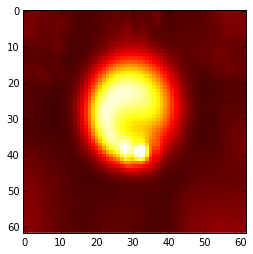

In [14]:
plt.imshow(T[0][:,:,focplaneZpix], vmin=37.0, vmax=50.0, interpolation='none', cmap=image.cm.hot )

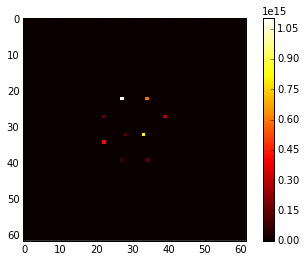

In [42]:
plt.imshow(CEM[:,:,focplaneZpix], interpolation='none', cmap=image.cm.hot )
plt.colorbar()

In [ ]:
T[0] = 37.0
CEM[:]=0
interpTimes = np.arange(0.0,20.0, 1.0)
interpTemp = np.zeros([len(interpTimes)])

times = np.arange(0.0,30.2, 15.0)
pbheDict = {'Freeflow':1, 'interpTimes':interpTimes, 'intepolatedTemp': interpTemp, 'interpFunc':np.max}
ablation_utils.sonicate4D(simPhysGrid,times[0:-1],times[1:],uamp,uxyz,unvec, use_gpu=True, CEM=CEM, 
                          RSkeys={'subsampN':10,'ROC':0.14,'subsampDiam':0.0033,'gpublocks':256}, 
                          PBkeys=pbheDict);

In [88]:
tstarts[1:]

array([  5.,  10.,  15.,  20.,  25.])

In [226]:
passTime = ablation_utils.trajTotalTime(*tuple(traj))

In [302]:
pxyz,r = geom.ring(0.004,3)
#pxyz=[[0.0, 0.0, 0.0]]
T[0] = 37.0
CEM[:]=0
traj=[10.0, 4.0, 140.0, 1.0, 5.0, 2.0]

Npass=2

RR = 4*np.ones_like(T[0])
def temp2cem(temp3d ):
    RR[temp3d>43]=2.0
    return (RR**(temp3d-43))

passTime = ablation_utils.trajTotalTime(*tuple(traj)) + traj[-1]
totTime=Npass*passTime

(coords,nturns,numson)=ablation_utils.contstruct_circ_sonication_points(*tuple(traj))

interpTimes = np.arange(0,totTime, 1.0)
interpTemp = np.zeros([len(interpTimes)])
interpTempFocPlane = np.zeros([len(interpTimes), nx,ny])
interpCEMFocPlane = np.zeros_like(interpTempFocPlane)

interpCEMFocAxial = np.zeros([len(interpTimes), nx,nz])
interpTempAxial = np.zeros_like(interpCEMFocAxial)

interp240Vol = np.zeros([len(interpTimes)])
interp240VolON = np.zeros([len(interpTimes)])
#interp240VolOFF = np.zeros([len(interpTimes)])
#interpoDose = np.zeros([len(interpTimes)])

yi=floor(ny/2)

def calcDosageIntegrands(temp3d):
    tidx=calcDosageIntegrands.idx  
    #interpoDose[calcDosageIntegrands.idx] = np.max( temp2cem(temp3d) )
    calcDosageIntegrands.out1[calcDosageIntegrands.idx] = temp3d[:,:,focplaneZpix] 
    calcDosageIntegrands.out2[calcDosageIntegrands.idx] = CEM[:,:,focplaneZpix]
    calcDosageIntegrands.out3[calcDosageIntegrands.idx] = CEM[:,yi,:]
    calcDosageIntegrands.out4[calcDosageIntegrands.idx] = temp3d[:,yi,:] 
    calcDosageIntegrands.vol240[calcDosageIntegrands.idx] = np.sum( CEM>=240.0 )
    calcDosageIntegrands.vol240ON[calcDosageIntegrands.idx] = np.sum( CEM[ROION]>=240.0 )
    
    return np.max(temp3d)

calcDosageIntegrands.idx=0
calcDosageIntegrands.out1 = interpTempFocPlane
calcDosageIntegrands.out2=  interpCEMFocPlane
calcDosageIntegrands.out3=  interpCEMFocAxial
calcDosageIntegrands.out4=  interpTempAxial

calcDosageIntegrands.vol240= interp240Vol
calcDosageIntegrands.vol240ON= interp240VolON

pbheDict = dict(Freeflow=1, interpTimes=interpTimes, interpolatedTemp=interpTemp, interpFunc=calcDosageIntegrands, perfRate=0.0)

RaylSommDict = dict(subsampN=10,ROC=0.14,subsampDiam=0.0033,gpublocks=512)

for n in range(0,Npass):
    print("Pass %d / %d" %(n+1,Npass), end=' ')
    
    Ry_n = geom.getRotZYZarray(0.0, pi*n, 0.0)
    
    (times,focalpoint_coords_mm,CEM)=ablation_utils.trajectorySonication(traj, simPhysGrid, use_gpu=True, pxyz=pxyz, 
                                                    L1renorm=sqrt(powRenorm), CEM=CEM, verbose=True, Npass=1, alpha_acc=1.0,
                                                    RSkeys=RaylSommDict,tzero=n*passTime,PathRotMat=Ry_n,
                                                    PBkeys=pbheDict )


 22/ 22, 100% 

In [305]:
interpTemp0 = np.zeros([len(interpTimes)])
interpTempFocPlane0 = np.zeros([len(interpTimes), nx,ny])
interpCEMFocPlane0 = np.zeros_like(interpTempFocPlane0)
interpCEMFocAxial0 = np.zeros([len(interpTimes), nx,nz])
interpTempAxial0 = np.zeros_like(interpCEMFocAxial0)

interp240Vol0 = np.zeros([len(interpTimes)])
interp240VolON0 = np.zeros([len(interpTimes)])

pbheDict['interpolatedTemp'] = interpTemp0

calcDosageIntegrands.idx=0
calcDosageIntegrands.out1 = interpTempFocPlane0
calcDosageIntegrands.out2=  interpCEMFocPlane0
calcDosageIntegrands.out3=  interpCEMFocAxial0
calcDosageIntegrands.out4=  interpTempAxial0
calcDosageIntegrands.vol240= interp240Vol0
calcDosageIntegrands.vol240ON= interp240VolON0

T[0]=37
CEM[:]=0

for n in range(0,Npass):
    print("Pass %d / %d" %(n+1,Npass), end=' ')
    
    Ry_n = geom.getRotZYZarray(0.0, pi*n, 0.0)
    
    (times,focalpoint_coords_mm,CEM)=ablation_utils.trajectorySonication(traj, simPhysGrid, use_gpu=True, pxyz=None, 
                                                L1renorm=sqrt(powRenorm), CEM=CEM, verbose=True, Npass=1,
                                                RSkeys=RaylSommDict, tzero=n*passTime,PathRotMat=Ry_n,
                                                PBkeys=pbheDict )

 22/ 22, 100% 

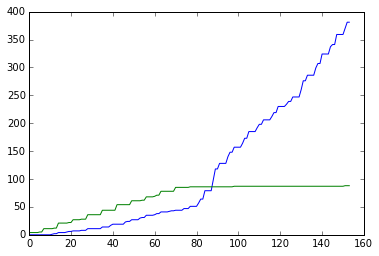

In [303]:
plt.plot(interpTimes, np.sum(interpCEMFocPlane >=240,axis=(1,2)))
plt.plot(interpTimes, np.sum(interpCEMFocPlane0 >=240,axis=(1,2)))

In [257]:
times

array([  0.,   5.,   7.,  12.,  14.,  19.,  21.,  26.,  28.,  33.,  35.,
        40.,  42.,  47.,  49.,  54.,  56.,  61.,  63.,  68.,  70.,  75.,
        77.])

In [258]:
passTime

75.0

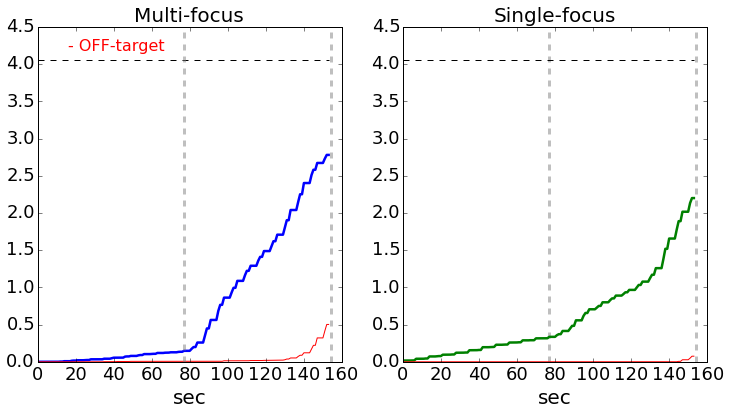

In [306]:

voxVolmL=(dx*dy*dz)*1e9*1e-3
totOnVol=voxVolmL*np.sum(ROION)


plt.figure(figsize=(12,6))
ax=plt.subplot(121)
ax.set_xlabel('sec', fontsize=20)
ax.tick_params(labelsize=18)
plt.title('Multi-focus', fontsize=20)
multicolor=(0,0,0.8)
#plt.plot(interpTimes, interp240Vol, '--', color='0.0', linewidth=1.0 )
plt.plot(interpTimes, voxVolmL*interp240VolON, '-',color='blue', linewidth=2.5  )
plt.plot(interpTimes, voxVolmL*(interp240Vol - interp240VolON), color='red' )
plt.plot(interpTimes[[0,-1]], [totOnVol,totOnVol], '--k')
plt.text(0.1, 0.93, '- OFF-target',transform=ax.transAxes, fontsize=16,fontdict=dict(color='red'))


ax2=plt.subplot(122)
ax2.set_ylim(bottom=0.0, top=ax.get_ylim()[1])
ax2.set_xlabel('sec', fontsize=20)
ax2.tick_params(labelsize=18)
plt.title('Single-focus', fontsize=20)

vlineOpt = dict(color=[0.5, 0.5, 0.5], linestyle='--',linewidth=3.0,alpha=0.5)
for n in range(1,Npass+1):
    ax.axvline(x=passTime*n, **vlineOpt)
    ax2.axvline(x=passTime*n, **vlineOpt)

#plt.plot(interpTimes, interp240Vol0, '--', color='0.0', linewidth=1.0 )
plt.plot(interpTimes, voxVolmL*interp240VolON0, '-',color='green', linewidth=2.5 )
plt.plot(interpTimes, voxVolmL*(interp240Vol0 - interp240VolON0), color='red', linewidth=1.0 )
plt.plot(interpTimes[[0,-1]], [totOnVol,totOnVol], '--k')

#plt.plot(interpTimes, interp240VolON0, color=multicolor )

In [93]:
traj

[10.0, 4.0, 140.0, 0.5, 10.0, 2.0]

In [20]:
times

array([   0.  ,    2.25,    4.25,    6.5 ,    8.5 ,   10.75,   12.75,
         15.  ,   17.  ,   19.25,   21.25,   23.5 ,   25.5 ,   27.75,
         29.75,   32.  ,   34.  ,   36.25,   38.25,   40.5 ,   42.5 ,
         44.75,   46.75,   49.  ,   51.  ,   53.25,   55.25,   57.5 ,
         59.5 ,   61.75,   63.75,   66.  ,   68.  ,   70.25,   72.25,
         74.5 ,   76.5 ,   78.75,   80.75,   83.  ,   85.  ,   87.25,
         89.25,   91.5 ,   93.5 ,   95.75,   97.75,  100.  ,  102.  ,
        104.25,  106.25,  108.5 ,  110.5 ,  112.75,  114.75,  117.  ,
        119.  ,  121.25,  123.25,  125.5 ,  127.5 ,  129.75,  131.75,
        134.  ,  136.  ,  138.25,  140.25,  142.5 ,  144.5 ,  146.75,
        148.75,  151.  ,  153.  ,  155.25,  157.25,  159.5 ,  161.5 ])

In [43]:
interpTemp

array([ 37.        ,  41.05471039,  43.96806717,  46.00800705,
        47.85479736,  49.39571762,  50.59305954,  51.7647171 ,
        52.80634308,  53.6551857 ,  54.43512726,  51.47883987,
        49.4723053 ,  48.06776047,  47.20140076,  49.03648376,
        50.57025528,  51.76346207,  52.93196869,  53.97116089,
        54.8179245 ,  55.59560394,  52.59848404,  50.56233597,
        49.13495636,  48.17824554,  48.43783188,  49.88982773,
        51.02491379,  52.15274811,  53.15925598,  53.98154449,
        54.73821259,  52.01295471,  49.96459961,  48.49786377,
        47.49649429,  49.23184967,  50.70701981,  51.86148071,
        52.99817276,  54.01428986,  54.84581757,  55.61216736,
        53.11911011,  51.38721848,  50.17712784,  49.33965683,
        49.86480713,  51.33136368,  52.47703552,  53.60215759,
        54.604702  ,  55.42243195,  56.18340302,  53.64890671,
        51.71400452,  50.35069275,  49.43432617,  48.94551468,
        50.36014175,  51.45798111,  52.5304451 ,  53.48

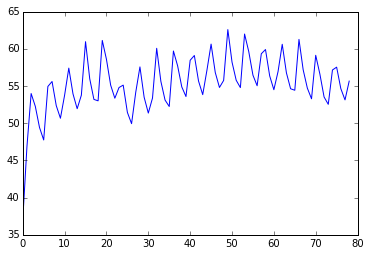

In [16]:
plt.plot(interpTimes,interpTemp)

In [223]:
def createFigureAnimator(tempStack, tempAxialStack, cemStack, cemAxialStack):

    extXY = 100*np.array( [yrp[0],yrp[-1],xrp[-1],xrp[0]] )
    extZX = 100*np.array( [zrp[0],zrp[-1],xrp[-1],xrp[0]] )

    fig,axTable=plt.subplots(nrows=2,ncols=2,sharey=True,sharex=False,squeeze=False,gridspec_kw=dict(wspace=0.05,hspace=0.1), figsize=(14,14))

    ax=axTable[0,0]
    im=ax.imshow(tempStack[-1,:,:], vmin=37.0, vmax=50.0,cmap=image.cm.hot,interpolation='none', extent=extXY)
    ax.imshow( ROION[:,:,focplaneZpix] , extent=extXY, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
    ax.plot(coords[:,1] /10,coords[:,0]/10,'--o')
    cb=plt.colorbar(orientation='horizontal',mappable=im,ax=ax, ticks = np.arange( *(im.get_clim() +(3,)) ) )
    cb.set_label('C',fontsize=20)
    cb.ax.tick_params(labelsize=20)
    ax.set_ylabel('cm', fontsize=20)

    ax=axTable[0,1]
    im2=ax.imshow(cemStack[-1,:,:], vmin=0.0, vmax=240.0,cmap=image.cm.hot,interpolation='none', extent=extXY)
    ax.imshow( ROION[:,:,focplaneZpix] , extent=extXY, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
    cb=plt.colorbar(orientation='horizontal',mappable=im2,ax=ax,ticks=[0,40,80,120,160,200,240])
    cb.set_label('CEM',fontsize=20)
    cb.ax.tick_params(labelsize=20)

    ax=axTable[1,0]
    imT=ax.imshow(tempAxialStack[-1,:,:], vmin=37.0, vmax=50.0, cmap=image.cm.hot,interpolation='none', extent=extZX)
    ax.imshow( ROION[:,yi,:] ,vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none',  extent=extZX)
    cb=plt.colorbar(orientation='horizontal',mappable=imT, ax=ax, ticks = np.arange( *(im.get_clim() +(3,)) ) )
    cb.set_label('CEM',fontsize=20)
    cb.ax.tick_params(labelsize=20)
    ax.set_ylabel('cm', fontsize=20)

    ax=axTable[1,1]
    im3=ax.imshow(cemAxialStack[-1,:,:], vmin=0.0, vmax=240.0,cmap=image.cm.hot,interpolation='none', extent=extZX)
    ax.imshow( ROION[:,yi,:] , extent=extZX, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
    cb=plt.colorbar(orientation='horizontal',mappable=im3,ax=ax,ticks=[0,40,80,120,160,200,240])
    cb.set_label('CEM',fontsize=20)
    cb.ax.tick_params(labelsize=20)

    for ax in axTable.flatten():
        ax.set_xlabel('cm', fontsize=20)
        ax.tick_params(labelsize=18)

    clipDuration=10.0
    numUniqueFrames=cemStack.shape[0]
    def makeframe(t):
        t/clipDuration
        ti= int(np.floor( numUniqueFrames*t/clipDuration ))
        im.set_data(tempStack[ti,:,:]);
        imT.set_data(tempAxialStack[ti,:,:]);
        im2.set_data(cemStack[ti,:,:]);
        im3.set_data(cemAxialStack[ti,:,:]);
        return mplfig_to_npimage(fig)
    
    animation =mpy.VideoClip(makeframe, duration=10.0);
    
    return (makeframe, animation, fig)
    

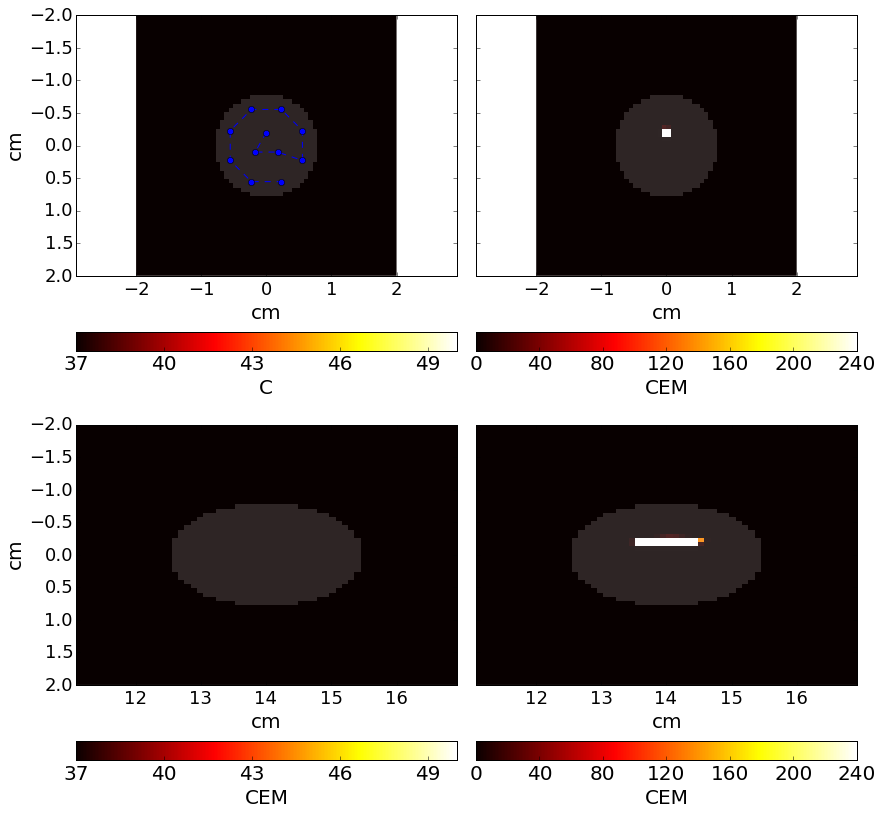

In [308]:
mf0, anim0, fig0 = createFigureAnimator( interpTempFocPlane0, interpTempAxial0, interpCEMFocPlane0, interpCEMFocAxial0);

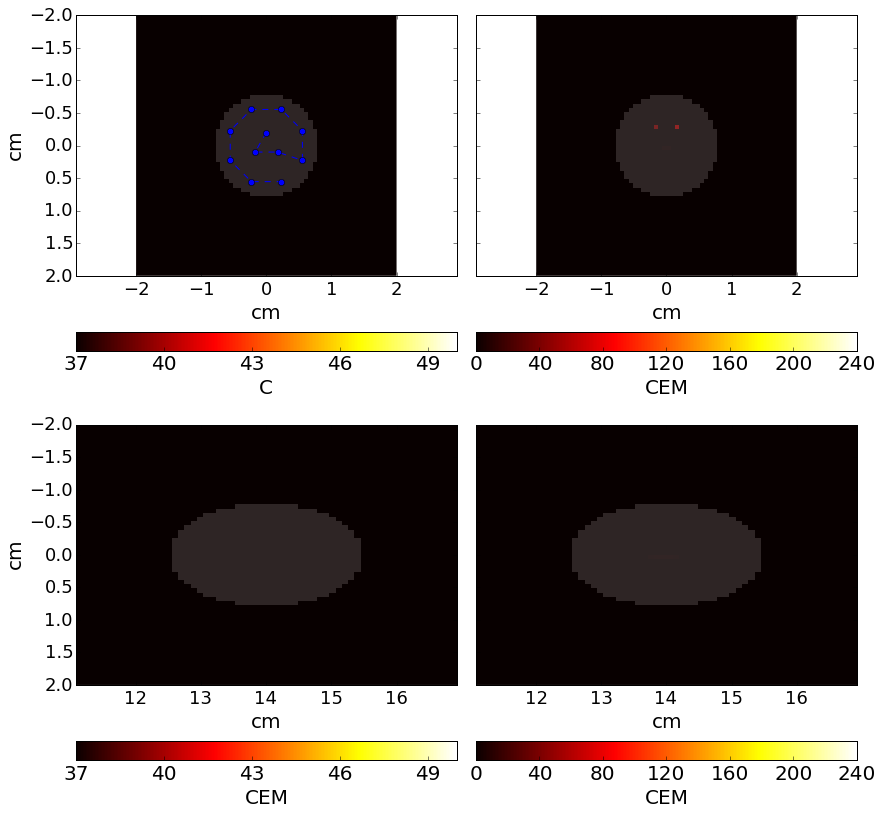

In [309]:
mf1, anim1,fig1 = createFigureAnimator( interpTempFocPlane, interpTempAxial, interpCEMFocPlane, interpCEMFocAxial)

In [310]:
outdir='C:\\Users\\Vandiver\\Documents\\HiFU\\code\\AblationSims\\trajectory_compare\\'
#anim0.write_videofile(outdir+'test0.mp4',fps=20)
anim0.write_videofile(outdir+'sp=1.0_dw=5.0_I=2500_d=0mm_N=1_Np=2_flip.mp4',fps=20)
anim1.write_videofile(outdir+'sp=1.0_dw=5.0_I=2500_d=3.5mm_N=3_Np=2_flip.mp4',fps=20)
#animation.write_videofile(outdir+'test1_I=2500_d=2.5mm_N=5.mp4',fps=20)

[MoviePy] >>>> Building video C:\Users\Vandiver\Documents\HiFU\code\AblationSims\trajectory_compare\sp=1.0_dw=5.0_I=2500_d=0mm_N=1_Np=2_flip.mp4
[MoviePy] Writing video C:\Users\Vandiver\Documents\HiFU\code\AblationSims\trajectory_compare\sp=1.0_dw=5.0_I=2500_d=0mm_N=1_Np=2_flip.mp4


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\Users\Vandiver\Documents\HiFU\code\AblationSims\trajectory_compare\sp=1.0_dw=5.0_I=2500_d=0mm_N=1_Np=2_flip.mp4 

[MoviePy] >>>> Building video C:\Users\Vandiver\Documents\HiFU\code\AblationSims\trajectory_compare\sp=1.0_dw=5.0_I=2500_d=3.5mm_N=3_Np=2_flip.mp4
[MoviePy] Writing video C:\Users\Vandiver\Documents\HiFU\code\AblationSims\trajectory_compare\sp=1.0_dw=5.0_I=2500_d=3.5mm_N=3_Np=2_flip.mp4


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\Users\Vandiver\Documents\HiFU\code\AblationSims\trajectory_compare\sp=1.0_dw=5.0_I=2500_d=3.5mm_N=3_Np=2_flip.mp4 



In [274]:
tp1=np.where(interpTimes[1:]>=passTime)[0][0]

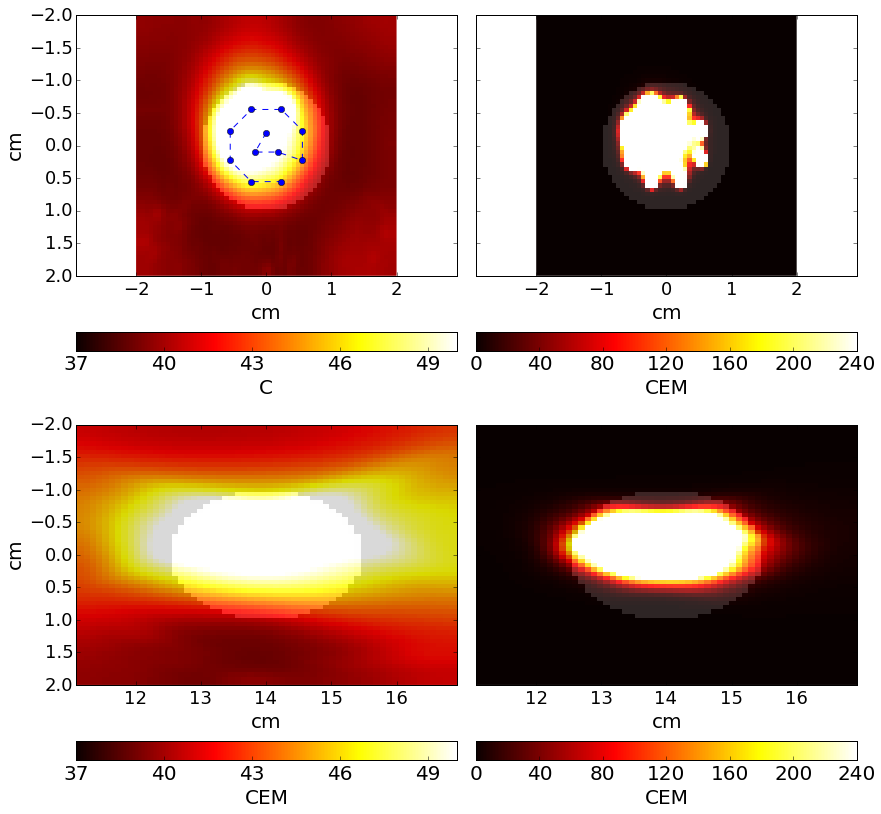

In [313]:
tempStack=interpTempFocPlane0
tempAxialStack=interpTempAxial0
cemStack=interpCEMFocPlane0
cemAxialStack=interpCEMFocAxial0
extXY = 100*np.array( [yrp[0],yrp[-1],xrp[-1],xrp[0]] )
extZX = 100*np.array( [zrp[0],zrp[-1],xrp[-1],xrp[0]] )

fig,axTable=plt.subplots(nrows=2,ncols=2,sharey=True,sharex=False,squeeze=False,gridspec_kw=dict(wspace=0.05,hspace=0.1), figsize=(14,14))

ti=tp1
ti=-1

ax=axTable[0,0]
im=ax.imshow(tempStack[ti,:,:], vmin=37.0, vmax=50.0,cmap=image.cm.hot,interpolation='none', extent=extXY)
ax.imshow( ROION[:,:,focplaneZpix] , extent=extXY, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
ax.plot(coords[:,1] /10,coords[:,0]/10,'--o')
cb=plt.colorbar(orientation='horizontal',mappable=im,ax=ax, ticks = np.arange( *(im.get_clim() +(3,)) ) )
cb.set_label('C',fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_ylabel('cm', fontsize=20)

ax=axTable[0,1]
im2=ax.imshow(cemStack[ti,:,:], vmin=0.0, vmax=240.0,cmap=image.cm.hot,interpolation='none', extent=extXY)
ax.imshow( ROION[:,:,focplaneZpix] , extent=extXY, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
cb=plt.colorbar(orientation='horizontal',mappable=im2,ax=ax,ticks=[0,40,80,120,160,200,240])
cb.set_label('CEM',fontsize=20)
cb.ax.tick_params(labelsize=20)

ax=axTable[1,0]
imT=ax.imshow(tempAxialStack[ti,:,:], vmin=37.0, vmax=50.0, cmap=image.cm.hot,interpolation='none', extent=extZX)
ax.imshow( ROION[:,yi,:] ,vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none',  extent=extZX)
cb=plt.colorbar(orientation='horizontal',mappable=imT, ax=ax, ticks = np.arange( *(im.get_clim() +(3,)) ) )
cb.set_label('CEM',fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_ylabel('cm', fontsize=20)

ax=axTable[1,1]
im3=ax.imshow(cemAxialStack[ti,:,:], vmin=0.0, vmax=240.0,cmap=image.cm.hot,interpolation='none', extent=extZX)
ax.imshow( ROION[:,yi,:] , extent=extZX, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
cb=plt.colorbar(orientation='horizontal',mappable=im3,ax=ax,ticks=[0,40,80,120,160,200,240])
cb.set_label('CEM',fontsize=20)
cb.ax.tick_params(labelsize=20)

for ax in axTable.flatten():
    ax.set_xlabel('cm', fontsize=20)
    ax.tick_params(labelsize=18)

  if __name__ == '__main__':



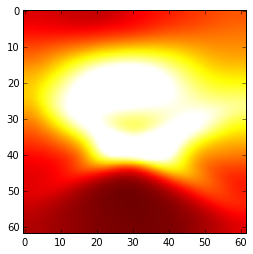

In [62]:
plt.imshow(T[0,:,ny/2,:],vmin=37,vmax=50,cmap=image.cm.hot)

In [7]:
extZX = 100*np.array( [zrp[0],zrp[-1],xrp[-1],xrp[0]] )

pxyz,r = geom.ring(0.0025,5)
uamp1 = transducers.get_focused_element_vals(simPhysGrid['k0'],uxyz, pxyz+[0.0, 0., 0.14], np.ones(len(pxyz)), L1renorm=sqrt(powRenorm) ) 
pp1 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'],uxyz,unvec,uamp1,xrp,yrp,zrp,subsampN=10,ROC=0.14,subsampDiam=0.0033, gpublocks=512)  
Ip1 = np.abs(pp1)**2 / (rho*c0)

In [61]:
np.max(Ip1)

17885506.522125684

  from ipykernel import kernelapp as app



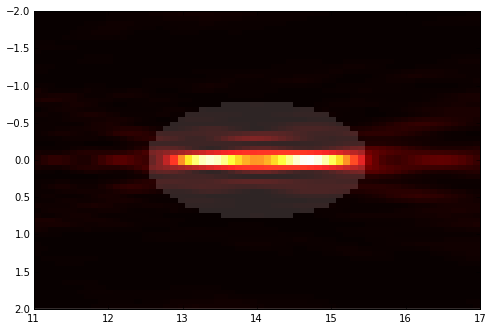

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(Ip1[:,ny/2,:],cmap=image.cm.hot,interpolation='none',extent=extZX)
plt.imshow( ROION[:,yi,:] , extent=extZX, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')

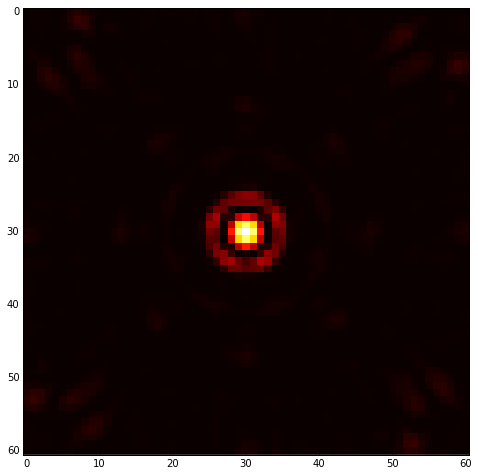

In [63]:
plt.figure(figsize=(8,8))
plt.imshow(Ip1[:,:,focplaneZpix],cmap=image.cm.hot,interpolation='none')

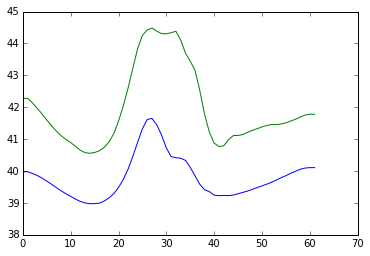

In [94]:
plt.plot( interpTempFocPlane0[-1,45,:] )
plt.plot( interpTempFocPlane[-1,45,:] )

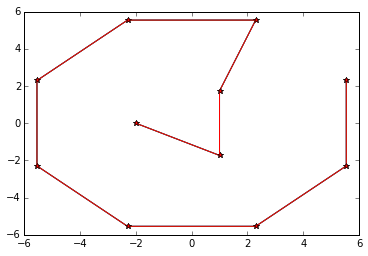

In [206]:
plotTraj([1.0,5.0,2.0]);
plotTraj([2.0,2.25,2.0]);
plotTraj([1.5,3,0.0]);

In [299]:
points,nt,numSon = ablation_utils.contstruct_circ_sonication_points(10,4, 140, 0.5 , 10, 0)

In [300]:
(points - [0., 0., 140.0]).dot(Ry_n)

array([[  2.00000000e+00,   2.44929360e-16,   2.44929360e-16],
       [ -1.00000000e+00,  -1.73205081e+00,  -1.22464680e-16],
       [ -1.00000000e+00,   1.73205081e+00,  -1.22464680e-16],
       [ -2.29610059e+00,   5.54327720e+00,  -2.81191224e-16],
       [  2.29610059e+00,   5.54327720e+00,   2.81191224e-16],
       [  5.54327720e+00,   2.29610059e+00,   6.78855667e-16],
       [  5.54327720e+00,  -2.29610059e+00,   6.78855667e-16],
       [  2.29610059e+00,  -5.54327720e+00,   2.81191224e-16],
       [ -2.29610059e+00,  -5.54327720e+00,  -2.81191224e-16],
       [ -5.54327720e+00,  -2.29610059e+00,  -6.78855667e-16],
       [ -5.54327720e+00,   2.29610059e+00,  -6.78855667e-16]])

In [204]:
ablation_utils.trajTotalTime(10,4,140,3/2,3,1)

43.0

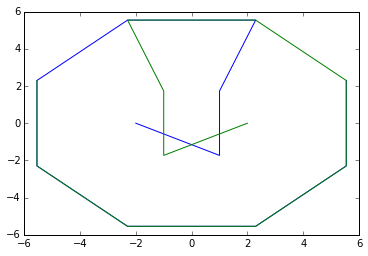

In [297]:
plt.plot(points[:,0], points[:,1])
points=points.dot(Ry_n)
plt.plot(points[:,0], points[:,1])